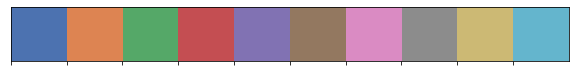

In [1]:
from utils import *
from model_avg_paper.stats import model_avg
from model_avg_paper import *
from jk import *

import lsqfit
import gvar as gv

import os
import platform
import h5py
import numpy as np
import matplotlib.pyplot as plt

userDir=os.path.expanduser('~')
baseDir=os.path.join(userDir,'Documents','LatticeQCD','PIPI')

beta=4.03
mh=0.2
ncStep=5
NT=64

# TODO: can normalize correlator

In [2]:
def get_avg_corr_folded(sourceTimes, pionDir, baseName, h5function):
    pionCorrs=get_all_source_corrs(pionDir, baseName, sourceTimes, ncStart, ncFinish, ncStep, h5function)

    avgPionCorr=pionCorrs[sourceTimes[0]]
    for t0 in sourceTimes[1:]:
        avgPionCorr+=pionCorrs[t0]
    avgPionCorr=avgPionCorr/len(sourceTimes)

    avgPionCorr=np.array([foldCorr(c,NT) for c in avgPionCorr])

    return avgPionCorr

## Pion

In [3]:
mls = [0.03,0.04,0.05,0.075,0.1,0.125,0.15,0.2]
pionModelAvgs = {}
pionObsTmin = {}
pionProbTmin = {}
pionCorrs = {}
for ml in mls:
    pionDir=get_pion_dir(baseDir,beta,ml,mh)
    baseName="wall_ll"

    ncStart, ncFinish = get_nc_start_fin(pionDir)
    NCFG = (ncFinish-ncStart)/ncStep

    sourceTimes=[i for i in range(0,64,8)]
    avgPionCorr=get_avg_corr_folded(sourceTimes, pionDir, baseName, get_pion_from_file)

    nmean = lambda data : np.mean(data,axis=0)

    mean,cov = jackKnifeCov(nmean, avgPionCorr)
    mean=np.real(np.array(mean))
    cov=np.real(np.array(cov))

    tiStart=5
    tiEnd=20
    tfStart=16
    tfEnd=NT/2
    obsVStmin, probVStmin = perform_many_fits(mean, cov, tiStart, tiEnd, tfStart, tfEnd, NT)
    mavg=model_avg(obsVStmin,probVStmin)
    
    pionModelAvgs[ml]=mavg
    pionObsTmin[ml]=obsVStmin
    pionProbTmin[ml]=probVStmin
    pionCorrs[ml]=avgPionCorr

In [4]:
pionModelAvgs

{0.03: 0.24880(48),
 0.04: 0.29208(34),
 0.05: 0.33198(35),
 0.075: 0.41804(25),
 0.1: 0.49719(23),
 0.125: 0.57176(16),
 0.15: 0.63923(20),
 0.2: 0.76763(15)}

In [5]:
e0 = lambda ml, data : data[ml].mean
e0err = lambda ml, data : data[ml].sdev

<ErrorbarContainer object of 3 artists>

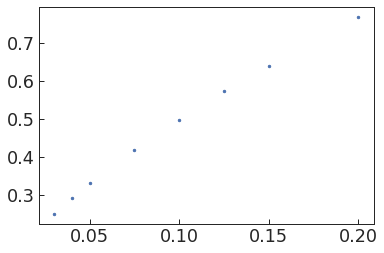

In [6]:
plt.errorbar(mls, [e0(ml,pionModelAvgs) for ml in mls], yerr=[e0err(ml,pionModelAvgs) for ml in mls],
    linestyle="None", marker=".", lw=1)

(0.18, 0.52)

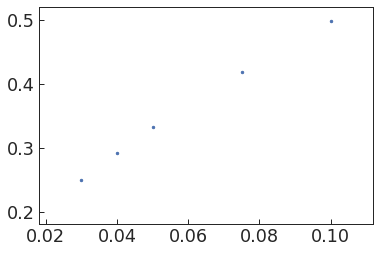

In [7]:
plt.errorbar(mls, [e0(ml,pionModelAvgs) for ml in mls], yerr=[e0err(ml,pionModelAvgs) for ml in mls],
    linestyle="None", marker=".", lw=1)
plt.xlim(0.018,0.112)
plt.ylim(0.18,0.52)

0.03


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


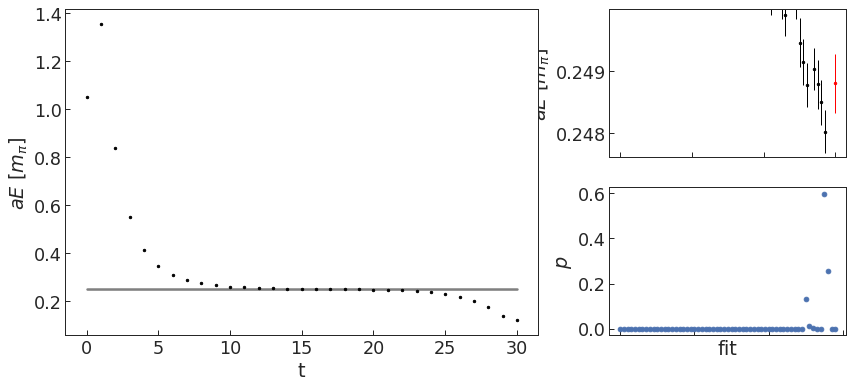

0.04


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


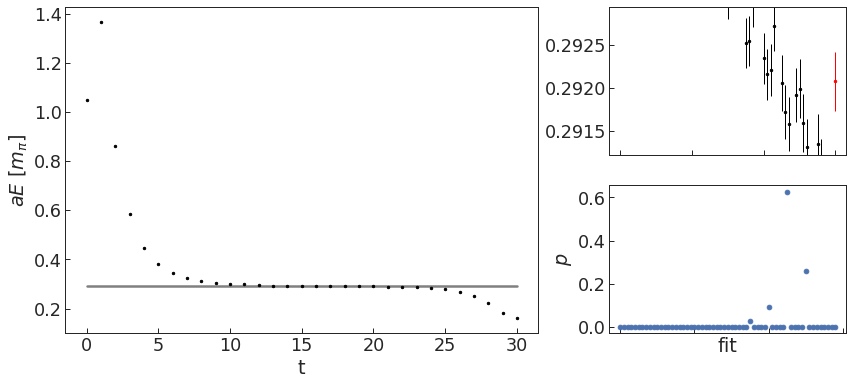

0.05


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


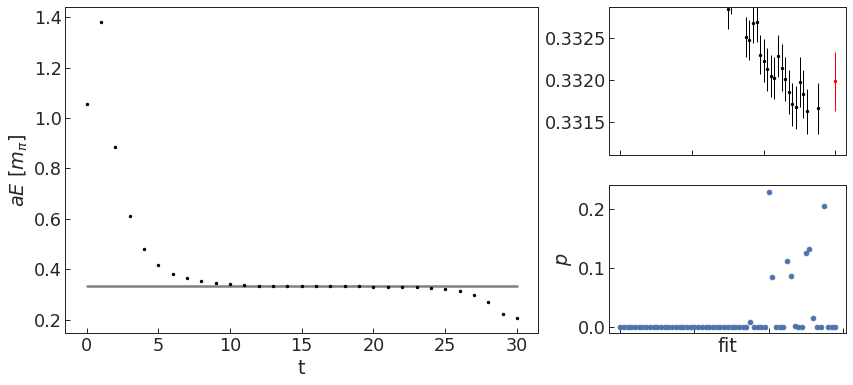

0.075


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


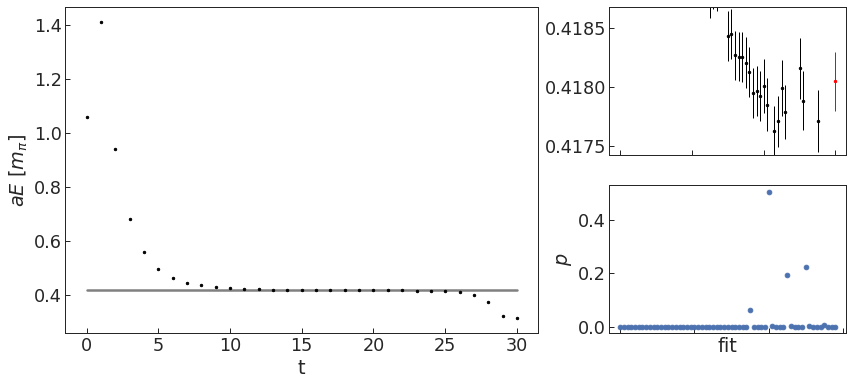

0.1


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


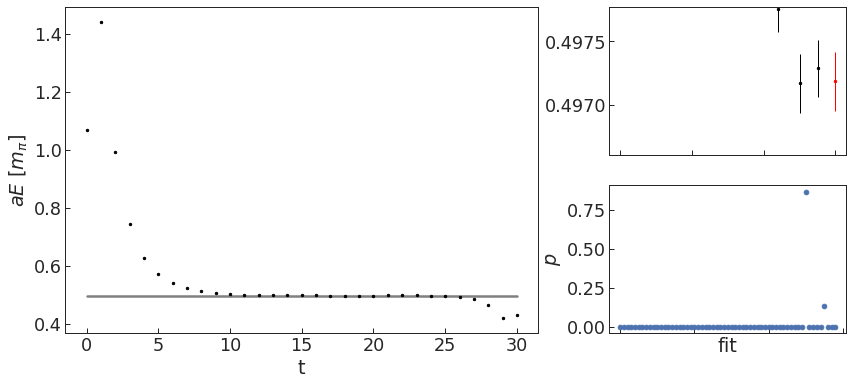

0.125


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


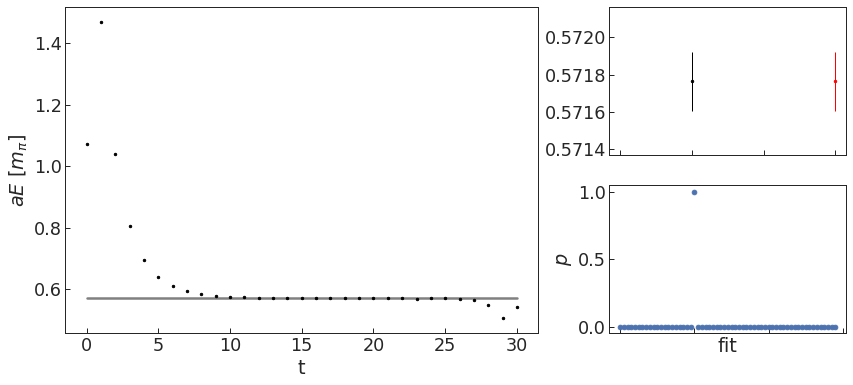

0.15


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


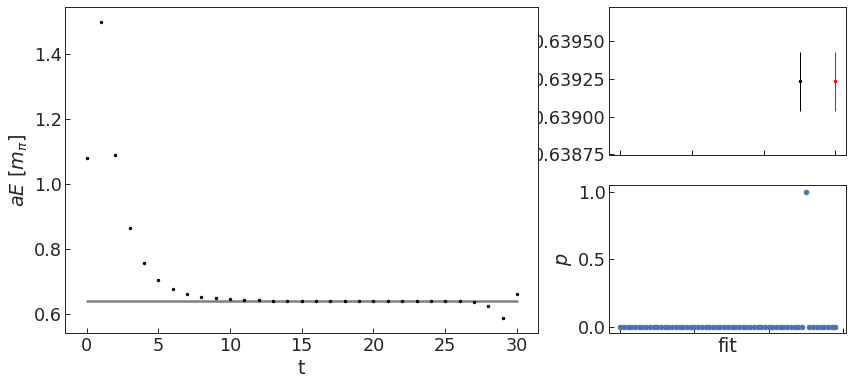

0.2


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


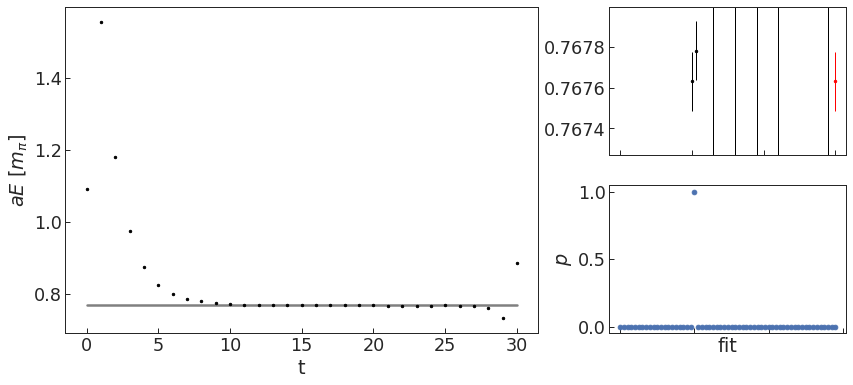

In [9]:
for ml in mls:
    print(ml)
    model_average_summary_plot(pionCorrs[ml],pionObsTmin[ml],pionProbTmin[ml],pionModelAvgs[ml])
    plt.show()

# Pi-pi

In [11]:
mls = [0.03,0.04,0.05,0.075,0.1,0.125,0.15,0.2]

pipiModelAvgs={}
pipiObsTmin={}
pipiProbTmin={}
pipiCorrs={}

for ml in mls:
    pionDir=get_pipi_dir(baseDir,beta,ml,mh)
    baseName="wall_llll"

    ncStart, ncFinish = get_nc_start_fin(pionDir)
    NCFG = (ncFinish-ncStart)/ncStep

    sourceTimes=[i for i in range(0,64,8)]
    avgPionCorr=get_avg_corr_folded(sourceTimes, pionDir, baseName, get_pipi_from_file)

    nmean = lambda data : np.mean(data,axis=0)

    mean,cov = jackKnifeCov(nmean, avgPionCorr)
    mean=np.real(np.array(mean))
    cov=np.real(np.array(cov))

    tiStart=5
    tiEnd=20
    tfStart=16
    tfEnd=NT/2
    obsVStmin, probVStmin = perform_many_fits(mean, cov, tiStart, tiEnd, tfStart, tfEnd, NT)

    mavg=model_avg(obsVStmin,probVStmin)

    pipiModelAvgs[ml]=mavg
    pipiObsTmin[ml]=obsVStmin
    pipiProbTmin[ml]=probVStmin
    pipiCorrs[ml]=avgPionCorr

/home/chris/anaconda3/envs/LQCD/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/Code/LQCD/SU4_PiPi_Analysis/model_avg_paper/stats.py:83: RuntimeWarning: invalid value encountered in true_divide
  pr_list /= np.sum(pr_list)


In [13]:
e0 = lambda ml, data : data[ml].mean
e0err = lambda ml, data : data[ml].sdev

In [14]:
pipiModelAvgs

{0.03: 0.51831(58),
 0.04: 0.59733(55),
 0.05: 0.67264(47),
 0.075: 0.84169(42),
 0.1: 1.00058(36),
 0.125: nan +- nan,
 0.15: nan +- nan,
 0.2: nan +- nan}

<ErrorbarContainer object of 3 artists>

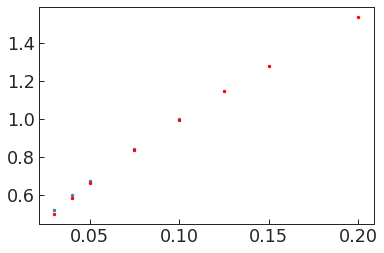

In [16]:
plt.errorbar(mls, [e0(ml,pipiModelAvgs) for ml in mls], yerr=[e0err(ml,pipiModelAvgs) for ml in mls],
    linestyle="None", marker=".", lw=1)
plt.errorbar(mls, [2*e0(ml,pionModelAvgs) for ml in mls], yerr=[2*e0err(ml,pionModelAvgs) for ml in mls],
    linestyle="None", marker=".", lw=1, color='Red')

(0.01, 0.1)

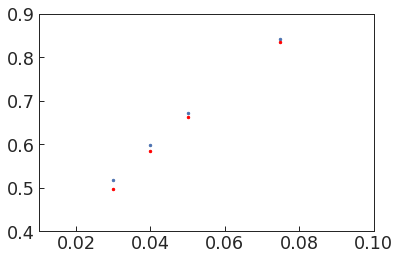

In [20]:
plt.errorbar(mls, [e0(ml,pipiModelAvgs) for ml in mls], yerr=[e0err(ml,pipiModelAvgs) for ml in mls],
    linestyle="None", marker=".", lw=1)
plt.errorbar(mls, [2*e0(ml,pionModelAvgs) for ml in mls], yerr=[2*e0err(ml,pionModelAvgs) for ml in mls],
    linestyle="None", marker=".", lw=1, color='Red')
plt.ylim(0.4,0.9)
plt.xlim(0.01,0.1)

0.03


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


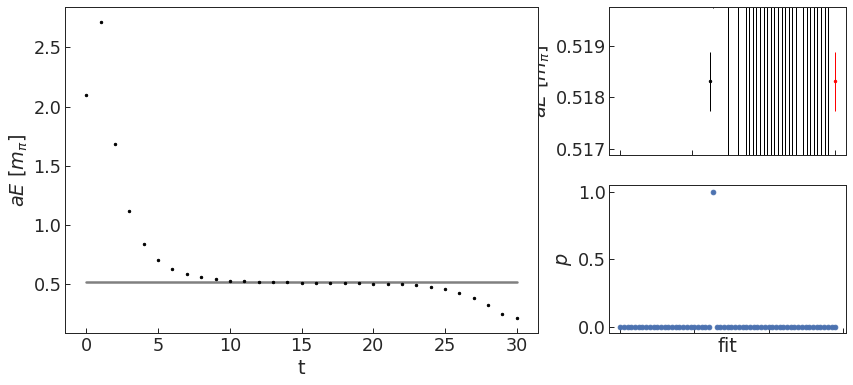

0.04


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


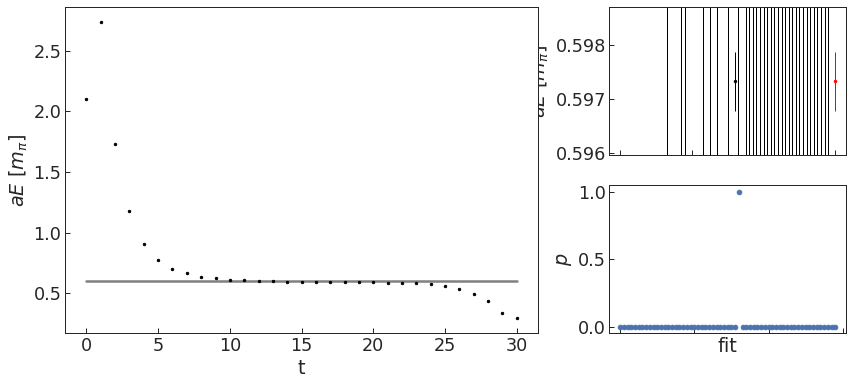

0.05


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


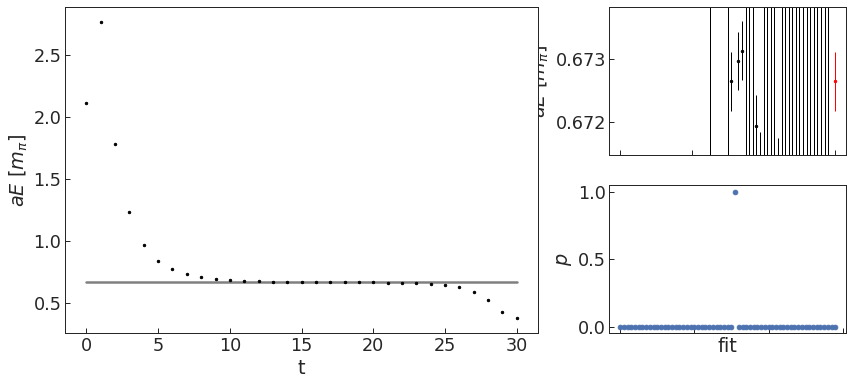

0.075


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


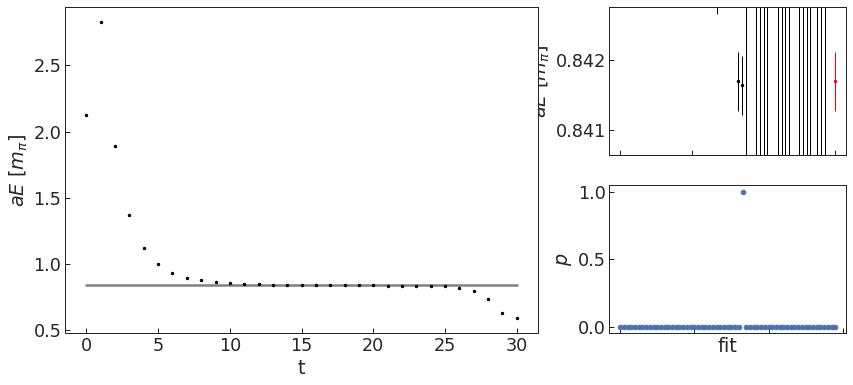

0.1


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


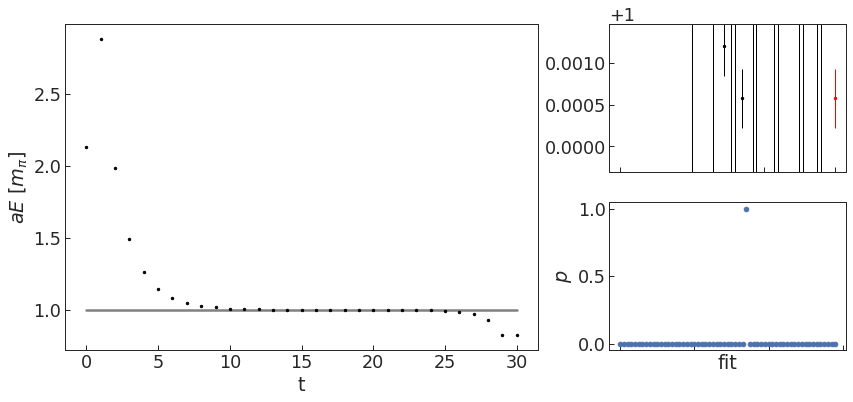

0.125


/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  except ValueError:


ValueError: Axis limits cannot be NaN or Inf

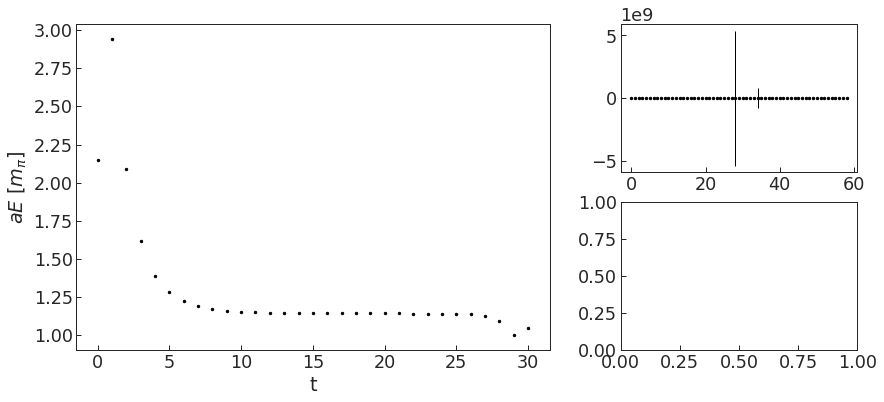

In [22]:
for ml in mls:
    print(ml)
    model_average_summary_plot(pipiCorrs[ml],pipiObsTmin[ml],pipiProbTmin[ml],pipiModelAvgs[ml])
    plt.show()